## Кластеризация (DBSCAN)

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

### Градиентный бустинг

In [2]:
from scipy.optimize import minimize

In [3]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """

        self.resid = []
        self.resid.append(y)
        self.trees = []
        self.y_pred = []
        
        for _ in range(self.n_estimators):
            self.y_pred.append(self._fit_predict_tree(x, self.resid[-1]))
            
            self.resid.append(y - np.sum(self.y_pred, axis = 0))

    def _fit_predict_tree(self, x, y):
        tree = DecisionTreeRegressor(max_depth = self.max_depth).fit(x, y)
        
        fun = lambda z: mean_squared_error(self.resid[-1], z * tree.predict(x))
        
        self.gamma = minimize(fun, 0.1).x
        
        self.trees.append((tree, self.gamma))
            
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_pred = np.zeros(len(x))
        
        for tree in self.trees:
            y_pred += tree[0].predict(x)*self.learning_rate*tree[1]
        
        return y_pred

In [4]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [6]:
np.random.seed(19052019)

bgt = GradientBoosting(385, 6, 0.035800235)
bgt.fit(X_train, y_train)
y_pred = bgt.predict(X_test)

In [7]:
mean_squared_error(y_test, y_pred)

9.520788200182755

### Прогнозируем задержки самолётов

На основании доступных данных о рейсе нужно определить, будет ли он задержан на 15 минут.


In [9]:
train = pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/flight_delays_test.csv')

In [10]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [11]:
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.703001315560974

In [13]:
! pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 95 kB/s 


In [16]:
from catboost import CatBoostClassifier

param_test = {
    #'depth': np.arange(1, 15, 1),
    #'learning_rate': np.arange(0.0, 1.1, 0.1),
    #'iterations': np.arange(1, 11, 1)
    #'leaf_estimation_iterations': np.arange(1, 11, 1),
    #'l2_leaf_reg': np.arange(0.0, 1.1, 0.1)
    #'bagging_temperature': np.arange(1,11,1)
    'early_stopping_rounds': np.arange(1,300,10)
}
gsearch = GridSearchCV(estimator = CatBoostClassifier(iterations = 100,learning_rate=0.8, depth = 12, leaf_estimation_iterations = 2, loss_function='CrossEntropy'), param_grid = param_test, scoring='roc_auc',n_jobs=4, cv=5)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

0:	learn: 0.4625302	total: 103ms	remaining: 10.2s
1:	learn: 0.4465269	total: 155ms	remaining: 7.61s
2:	learn: 0.4445765	total: 198ms	remaining: 6.41s
3:	learn: 0.4437412	total: 240ms	remaining: 5.76s
4:	learn: 0.4431443	total: 282ms	remaining: 5.36s
5:	learn: 0.4426451	total: 330ms	remaining: 5.18s
6:	learn: 0.4421389	total: 372ms	remaining: 4.94s
7:	learn: 0.4416121	total: 414ms	remaining: 4.76s
8:	learn: 0.4409757	total: 456ms	remaining: 4.61s
9:	learn: 0.4406794	total: 498ms	remaining: 4.49s
10:	learn: 0.4404128	total: 544ms	remaining: 4.4s
11:	learn: 0.4400040	total: 587ms	remaining: 4.31s
12:	learn: 0.4397258	total: 631ms	remaining: 4.22s
13:	learn: 0.4391795	total: 674ms	remaining: 4.14s
14:	learn: 0.4387041	total: 718ms	remaining: 4.07s
15:	learn: 0.4382417	total: 765ms	remaining: 4.01s
16:	learn: 0.4377948	total: 808ms	remaining: 3.94s
17:	learn: 0.4374625	total: 853ms	remaining: 3.88s
18:	learn: 0.4370197	total: 896ms	remaining: 3.82s
19:	learn: 0.4365521	total: 939ms	remainin

({'early_stopping_rounds': 1}, 0.6918450606558536)

In [17]:
cbc_model = CatBoostClassifier(learning_rate=0.83, 
                               depth = 12, 
                               leaf_estimation_iterations = 2, 
                               loss_function='CrossEntropy', 
                               early_stopping_rounds = 1,
                               bagging_temperature = 1,
                               metric_period = 200,
                               )
cbc_model.fit(X_train, y_train)
roc_auc_score(y_valid, cbc_model.predict_proba(X_valid)[:, 1])

0:	learn: 0.4601900	total: 51ms	remaining: 50.9s
200:	learn: 0.3964702	total: 8.66s	remaining: 34.4s
400:	learn: 0.3737080	total: 17.2s	remaining: 25.8s
600:	learn: 0.3568774	total: 25.8s	remaining: 17.1s
800:	learn: 0.3442607	total: 34.4s	remaining: 8.53s
999:	learn: 0.3338833	total: 42.9s	remaining: 0us


0.8760279674155506

### DBSCAN

In [18]:
from scipy.spatial import distance

In [19]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        self.X = X
        self.cluster = np.zeros(self.X.shape[0])
        self.clss = 1
        
        for x in range(self.X.shape[0]):
            
            
            if self.cluster[x] == 0:
                neighb = self.range_query(x)
                if len(neighb) < self.min_samples:
                    self.cluster[x] = -1
                else: 
                    self.cluster[x] = self.clss
                    self.grow_cluster(x, neighb)
                    self.clss += 1
                    
        return self.cluster
        
    def grow_cluster(self, root, neighbours):
        
        queue = set()
        queue.update(neighbours)
        
        while queue:
            vertex = queue.pop()
            if self.cluster[vertex] != self.clss:
                self.cluster[vertex] = self.clss
                
                neig = self.range_query(vertex)
                if len(neig) >= self.min_samples:
                    queue.update(self.range_query(vertex))

    def range_query(self, x):

        mask = list(map(lambda z: self.dist(z, self.X[x]), self.X))
        indx = [index for index, value in enumerate(mask) if value <= self.eps]
        return indx
        
    @staticmethod
    def dist(a, b):
        return distance.euclidean(a, b)
        

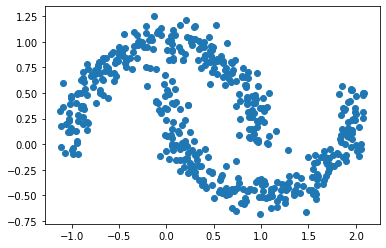

In [20]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

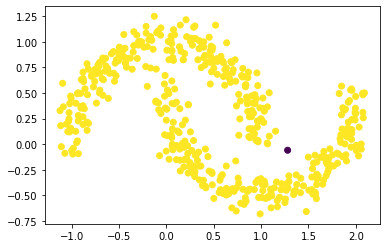

In [21]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

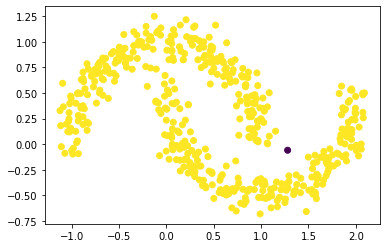

In [22]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

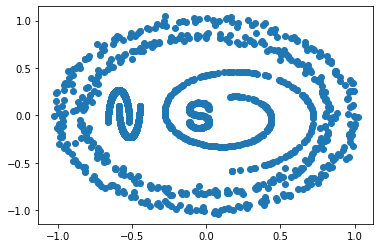

In [23]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll

K, _ = make_circles(n_samples=500, noise=0.025, factor = 0.83)
Z, _ = make_moons(n_samples=1000, noise=0)
Y, _ = make_s_curve(n_samples=200, noise=0.03)
W, _ = make_swiss_roll(n_samples=300, noise=0)

Z[:,0], Z[:,1] = (-1/14*Z[:,0] - 0.52), (-1/3*Z[:,1] + 0.1)

Y = Y[:,[-1,0]]

Y[:,0], Y[:,1] = (1/15*Y[:,1]- 0.05), (1/15*Y[:,0])

W = W[:,[-1,0]]

W[:,0], W[:,1] = (1/22*W[:,1] + 0.15), (-1/24*W[:,0]) 

X = np.vstack((K, Z, Y, W))
plt.scatter(X[:,0], X[:,1])
plt.show()

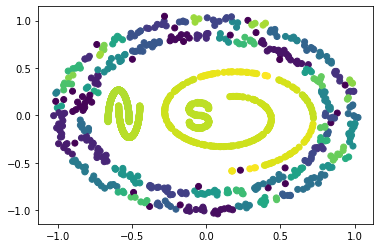

In [24]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.05, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

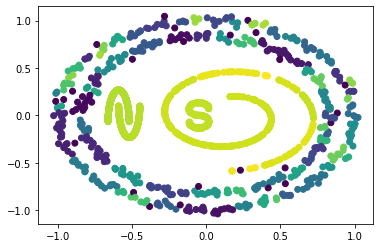

In [25]:
clusters = dbscan(eps=0.05, min_samples=2).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

In [26]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 30.7 ms, sys: 4.01 ms, total: 34.7 ms
Wall time: 37.4 ms


In [27]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 1min 32s, sys: 175 ms, total: 1min 32s
Wall time: 1min 32s
